In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf

from keras import Input

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, \
    TimeDistributed, RepeatVector, Dropout, GRU, AveragePooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, \
    precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [5]:
reactor_list[2]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,94.066570,22.030,0.22,2.92
2010-01-02,95.318860,21.985,0.22,3.04
2010-01-03,82.826748,21.740,0.22,3.00
2010-01-04,95.307918,21.815,0.22,2.97
2010-01-05,93.930636,21.890,0.23,2.94
...,...,...,...,...
2020-12-27,144.736842,22.540,0.23,3.41
2020-12-28,130.890052,22.535,0.24,3.10
2020-12-29,140.306122,22.660,0.25,3.15


In [6]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [7]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [9]:
join_list[1]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,88.649852,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,86.480363,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,96.370968,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,109.427609,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,100.929054,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.887324,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,152.173913,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)

In [11]:
X

array([[[ 90.94368341,  22.03      ,   0.23      , ...,          nan,
                  nan,          nan],
        [ 84.36532508,  21.985     ,   0.18      , ...,          nan,
                  nan,          nan],
        [ 94.54113924,  21.74      ,   0.21      , ...,          nan,
                  nan,          nan],
        ...,
        [107.93768546,  21.89      ,   0.23      , ...,          nan,
                  nan,          nan],
        [ 89.8744113 ,  21.73      ,   0.2       , ...,          nan,
                  nan,          nan],
        [ 94.62809917,  21.655     ,   0.21      , ...,          nan,
                  nan,          nan]],

       [[ 84.36532508,  21.985     ,   0.18      , ...,          nan,
                  nan,          nan],
        [ 94.54113924,  21.74      ,   0.21      , ...,          nan,
                  nan,          nan],
        [ 97.4025974 ,  21.815     ,   0.21      , ...,          nan,
                  nan,          nan],
        ...,


In [12]:
X.shape

(16044, 7, 41)

In [13]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 72.89it/s]


In [14]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

In [15]:
X[0]

array([[0.17449926, 0.37586548, 0.3255814 , 0.27717391,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.15989432, 0.37289812, 0.20930233, 0.32336957,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        

In [16]:
Y_normalize.shape

(16044, 1)

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Epoch 1/3
14439/14439 [==============================] - 13s 905us/step - loss: 0.5527 - binary_accuracy: 0.6901
Epoch 2/3
14439/14439 [==============================] - 12s 824us/step - loss: 0.4539 - binary_accuracy: 0.7427
Epoch 3/3
14439/14439 [==============================] - 12s 806us/step - loss: 0.4254 - binary_accuracy: 0.7644


In [19]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [20]:
Xtest.shape

(1605, 7, 41)

In [21]:
Yhat

array([[0.8761754 ],
       [0.9782087 ],
       [0.98512554],
       ...,
       [0.9842793 ],
       [0.9116802 ],
       [0.88895434]], dtype=float32)

In [22]:
Ytest

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [23]:
y_real = Ytest.astype(int)

In [24]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this func not necessarily optimized, could return to 
    doing this but not needed).
    '''
    f1_vals = []
    for i in range(1, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
        y_real = Ytest.astype(int)
        
        f1 = km.results(y_real, y_predict, binary=True)[3]
        
        if f1>0 and f1<1:
            f1_vals.append(f1)
        else:
            f1_vals.append(-1)            

    return (f1_vals.index(max(f1_vals))+1)/100

In [25]:
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

In [26]:
classes = ['High_svi', 'Low_svi']

In [27]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[371 141]
 [152 941]]


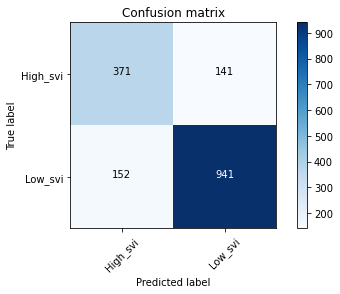

In [28]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [29]:
results = km.results(y_real, y_predict, binary=True)

In [30]:
results #accuracy, recall, precision, f1

(0.8174454828660436, 0.724609375, 0.7093690248565966, 0.7169082125603865)

In [31]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [32]:
auc(fpr, tpr)

0.8829983417200367

Text(0.5, 1.0, 'ROC curve')

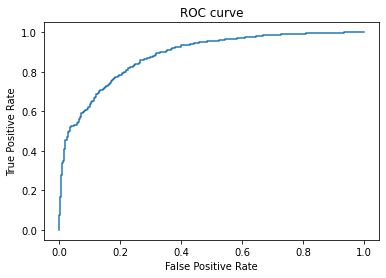

In [33]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [34]:
model_names = {1: 'Simple LSTM',
               2: 'Stacked LSTM',
               3: 'Bidirectional LSTM',
               4: 'CNN',
               5: 'CNN LSTM',
               6: 'LSTM Autoencoder',
               7: 'Deep CNN',
               8: 'GRU',
               9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-1):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            plt.plot(x, y, label=f'n_steps_in={i+1}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        #change Simple LSTM to a variable
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        #change Simple LSTM to a variable
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-1):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        #change Simple LSTM to a variable
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
        #change Simple LSTM to a variable
        plt.savefig(f"figures/{model_name} n_steps_in={z+1}.png", bbox_inches="tight")
        plt.close()

In [37]:
#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            model = Sequential()
            model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_predict = np.rint(Yhat).astype(int)
            y_real = Ytest.astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

###Just need to fill out the three functions for below. All other infrastructure is handled.###

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            
            model = Sequential()
            model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(20, activation='relu')))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_predict = np.rint(Yhat).astype(int)
            y_real = Ytest.astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 6 - having lots of trouble with this one
#For some reason we need steps_in to be at least 3 for this one
#This probably has to do with the pooling, Convolution, or Dropout layers
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(3, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(join_list, n_steps_in=3, n_steps_out = 1, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            model = Sequential()
            model.add(Conv1D(filters=128, 
                             kernel_size=2, 
                             activation='relu', 
                             name='extractor', 
                             input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dropout(0.3))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
            model.add(RepeatVector(10))
            model.add(Bidirectional(LSTM(50, activation='relu')))
            model.add(Dense(1))

            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)

            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 9 - having lots of trouble with this one
def train_GRU_CNN_model(epochs, steps_in, steps_out):
#     results_list = []
#     for i in range(1, steps_in):
#         for j in range(1, steps_out):
#             X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
#             X_normalize, Y_normalize, scalers = km.normalize(X, Y)
#             Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            
#             inp_seq = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
#             x = Bidirectional(GRU(100, return_sequences=True))(inp_seq)
#             x = AveragePooling1D(2)(x)
#             x = Conv1D(100, 3, activation='relu', padding='same',
#                        name='extractor')(x)
#             x = Flatten()(x)
#             x = Dense(16, activation='relu')(x)
#             x = Dropout(0.5)(x)

#             out = Dense(1, activation=LAST_ACTIVATION)(x)

#             model = Model(inp_seq, out)

            
#             model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
#             model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
#             Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
#             y_predict = np.rint(Yhat).astype(int)
#             y_real = Ytest.astype(int)
#             results_list.append(km.results(y_real, y_predict))
#     return results_list
    pass



In [39]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=3, n_steps_out = 1, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

model = Sequential()
model.add(Conv1D(filters=128, 
                 kernel_size=2, 
                 activation='relu', 
                 name='extractor', 
                 input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
model.add(RepeatVector(10))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)

Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

km.results(y_real, y_predict)

100%|██████████| 3/3 [00:00<00:00, 65.01it/s]


Epoch 1/2
12848/12848 [==============================] - 46s 4ms/step - loss: 0.6399
Epoch 2/2
12848/12848 [==============================] - 42s 3ms/step - loss: 0.6032


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (t

In [40]:
km.results(y_real, y_predict)

(0.7235367372353674,
 0.6863905325443787,
 0.5497630331753555,
 0.6105263157894737)

In [38]:

list_of_result_lists = {}
models_list = [6]

epochs = 2
steps_in = 4
steps_out = 2

for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

100%|██████████| 3/3 [00:00<00:00, 62.18it/s]


Epoch 1/2
12848/12848 [==============================] - 45s 4ms/step - loss: 0.7309
Epoch 2/2
12848/12848 [==============================] - 41s 3ms/step - loss: 0.6011


ValueError: Found input variables with inconsistent numbers of samples: [1605, 3212]

In [ ]:
classes = ['High_svi', 'Low_svi']

In [ ]:
cm = confusion_matrix(y_real, y_predict)

In [ ]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
result_list = km.results(y_real, y_predict)

In [ ]:
result_list